### Analyse de la pertinence d'un verdissement d'une flotte de véhicules automobiles à partir de données télématiques 

* Auteur: Justin Valet 
* Date: 13/08/2021
* Jeu de données: https://www.kaggle.com/yunlevin/levin-vehicle-telematics

#### 1) Packages python & gestion des données 

Le fichier utilisé est le suivant : allcars.csv

##### 1.2 Inputs utilisateurs

* import pandas as pd : pour la manipulation de données tabulaires
* import seaborn as sns  : pour la visualisation des données
* import numpy as np : package de manipulation de données à hautes performances 

In [54]:
import pandas as pd
import seaborn as sns
import numpy as np

##### 1.2 Inputs utilisateurs

* folder_file --> chemin vers le fichier allcars.csv

In [77]:
# reseignez le chemin vers le fichier
folder_file = ""

#### 2) Import, qualification, transformation et mise en qualité des données

##### 2.1 Inputs utilisateurs

Pour cette analyse, ne seront retenues que les variables suivantes: 

* timeStamp: variable temporelle
* tripID: un trajet (entre le moment où le véhicule a le moteur en marche et lorsque celui-ci est éteint)
* gps_speed: la vitesse collectée par le GPS pour chaque records (pour chaque seconde) - plus précise que celle du moteur
* deviceID: l'indentifiant du boitier et par conséquent du véhicule

Les autres variables n'ont pas été conservées car jugés trop techniques pour cette analyse. 

In [59]:
# liste des colonnes sélectionnés dans l'import du fichier au sein d'un pandas dataframe
col_to_use = ["timeStamp", "tripID", "gps_speed","deviceID"
             ]
data = pd.read_csv(folder_file+"allcars.csv", usecols=col_to_use)

In [60]:
print("ce jeu de données est composé de {} points collectés".format(data.shape[0]))
print("ce jeu de données est composé de {} véhicules".format(len(data["deviceID"].unique())))

ce jeu de données est composé de 7214695 points collectés
ce jeu de données est composé de 29 véhicules


##### 2.2 Transformations des données 

L'idée içi est de: 

* Créer une date unique pour chaque jour / deviceID à partir du timestamp  
* Convertir la vitesse GPS en KMh (Mph*1.6....)
* Calculer la distance parcouru par véhicule / s (pour un point) d = 1 * gps_speed(in KM/s)

In [61]:
# Convertir le timestamp en datetime format
data["timeStamp"] = pd.to_datetime(data["timeStamp"])

# extraire le date du jour pour un record
data["trip_date"] = data["timeStamp"].dt.date

# Convertir en KM/h
data["gps_speed"] = round(data["gps_speed"]*1.609344,0)

# Caluler la distance parcouru / s (pour un point)
data["distance"] = data["gps_speed"] / 3600

##### 2.3 Mise en qualité

* identification des valeurs nulles & suppression des valeurs nulles (de vitesse)
* identification des valeurs extrêmes

In [62]:
# Calcul du taux de complétude par variable 
100 - (data.isnull().sum() / data.shape[0])*100

timeStamp    100.00000
tripID       100.00000
gps_speed     70.72439
deviceID     100.00000
trip_date    100.00000
distance      70.72439
dtype: float64

In [63]:
# supression des valeurs nulles (comportement anormal du véhicule, à l'arrêt devrait être égal à zero)
data = data[~data["gps_speed"].isnull()].reset_index(drop=True)

<AxesSubplot:xlabel='gps_speed'>

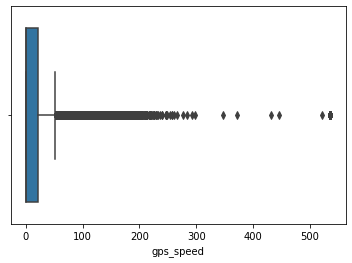

In [64]:
# boîte à moustache pour identifier les valeurs extrêmes
# On va considérer ici qu'une vitesse au-delà de 170 km/h est anormale (Perte de permis en france sur l'autoroute) 
sns.boxplot(x=data["gps_speed"])

In [65]:
# supprimer les valeurs extrêmes pour la vitesse
data = data[data["gps_speed"] < 170].reset_index(drop=True)

In [66]:
# identification des enrigistrements où le véhicule était à l'arrêt
data["is_null_gps_speed"] = (data["gps_speed"] == 0).astype(int)

#### 3) Création des vues aggrégées au niveau du TripID, de la journée et enfin au niveau du véhicule

##### 3.1 Vue par trajet

Pour cette vue, les données seront aggrégées aux niveaux: 

* Des trajets
* De la journée 
* Du véhicule 

L'idée est d'analyser / véhicule / jour / trajet:
* la vitesse moyenne / médiane / max
* distance parcourue par un trajet 
* durée du trajet

In [67]:
# Vue trajet
trip_agg = data.groupby(["deviceID", "tripID", "trip_date"]).agg(
                                                                {'timeStamp': ['min', 'max'], 
                                                                 'gps_speed': ['max', 'mean', 'median'], 
                                                                 'distance': ['sum'],
                                                                 'is_null_gps_speed': ['sum']
                                                                }
                                                                 ).reset_index()

trip_agg.columns = ["deviceID", "tripID", "trip_date", 
                    "min_timestamp", "max_timestamp", "speed_max",
                    "speed_mean", "speed_median", "distance", 
                    "num_seconds_null_speed"]

# calculer la durée du trajet en minutes 
trip_agg["trip_time"] = round((trip_agg["max_timestamp"] - trip_agg["min_timestamp"]).dt.total_seconds() / 60,0).astype(int)

# calculer le %  de secondes passée arrêtées / trajets
trip_agg["perc_null_points"] = (trip_agg["num_seconds_null_speed"]) / (trip_agg["trip_time"]*60)
trip_agg.loc[trip_agg["trip_time"]==0, "perc_null_points"] = 0 


trip_agg['val'] = 1

trip_agg.head()

,deviceID,tripID,trip_date,min_timestamp,max_timestamp,speed_max,speed_mean,speed_median,distance,num_seconds_null_speed,trip_time,perc_null_points,val
0,1,0,2017-10-31,2017-10-31 18:45:59,2017-10-31 18:51:10,13.0,0.548077,0.0,0.047500,288,5,0.960000,1
1,1,0,2017-11-09,2017-11-09 21:01:15,2017-11-09 21:19:07,77.0,47.247432,55.0,14.056111,99,18,0.091667,1
2,1,1,2017-10-13,2017-10-13 13:09:36,2017-10-13 13:09:36,0.0,0.000000,0.0,0.000000,1,0,0.000000,1
3,1,2,2017-10-13,2017-10-13 13:09:51,2017-10-13 13:09:57,0.0,0.000000,0.0,0.000000,3,0,0.000000,1
4,1,3,2017-10-13,2017-10-13 15:42:34,2017-10-13 15:43:16,0.0,0.000000,0.0,0.000000,43,1,0.716667,1


##### 3.2 Vue par jour

Pour cette vue, les données seront aggrégées aux niveaux: 

* De la journée 
* Du véhicule 

L'idée est d'analyser / véhicule / jour / trajet:
* distance parcourue / jour
* le % moyen d'arrêt / s
* le nombre de trajets / jour

In [68]:
day_agg = trip_agg.groupby(["deviceID", "trip_date"]).agg({ 
                                                 "distance":['sum'], 
                                                 "val": ["sum"], 
                                                 "perc_null_points":['mean'],
                                                           }).reset_index()

day_agg.columns = ["deviceID", "trip_date", "distance_sum", "num_trip_by_day", 'perc_null_points']
day_agg["distance_sum"] = round(day_agg["distance_sum"], 0)

# calculer le nombre de kilomètres moyen parcouru / trajet
day_agg["kmh_trip"] = np.divide(day_agg["distance_sum"], day_agg["num_trip_by_day"])
day_agg.loc[day_agg["distance_sum"]==0, "kmh_trip"] = 0 

##### 3.3 Vue par véhicule

Pour cette vue, les données seront aggrégées au niveau du véhicule. 

L'idée est d'analyser / véhicule:
    
* la distance totale parcourue
* la distance moyenne / jour 
* le nombre de trajets / jour

In [70]:
# calcul de la vue au véhicule
device_agg = day_agg.groupby(["deviceID"])["distance_sum", "num_trip_by_day", "kmh_trip", "perc_null_points"].mean().reset_index()

/Users/justinvalet/.virtualenvs/logistic-regression/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [71]:
# Calcul du nombre de jours où le véhicule a été utilisé 

device_agg = pd.merge(device_agg, day_agg.groupby("deviceID").size().reset_index().rename(columns={0:"num_days"}), on="deviceID", how="left")

# Calcul du nombre total de trajets pour chaque véhicule
device_agg = pd.merge(device_agg, trip_agg.groupby("deviceID").size().reset_index().rename(columns={0:"num_trip_total"}), on="deviceID", how="left")

# Arondis des variables pour une meilleure visibilité dans l'analyse
device_agg["distance_sum"] = round(device_agg["distance_sum"], 0).astype(int)
device_agg["num_trip_by_day"] = round(device_agg["num_trip_by_day"], 0).astype(int)
device_agg["kmh_trip"] = round(device_agg["kmh_trip"], 1)
device_agg["perc_null_points"] = round(device_agg["perc_null_points"], 1)

# Calcul de la distance totale parcourue par chaque véhicule

tmp = day_agg.groupby("deviceID").agg({"distance_sum":["sum"]}).reset_index()
tmp.columns = ["deviceID","distance_totale"]
device_agg = pd.merge(device_agg, tmp, on="deviceID", how="left")

# Calcul du trajet le plus long effectué

tmp = trip_agg.groupby("deviceID")["distance"].max().reset_index().rename(columns={'distance':'max_trip'})
device_agg = pd.merge(device_agg, tmp, on="deviceID", how="left")

device_agg.describe()

,deviceID,distance_sum,num_trip_by_day,kmh_trip,perc_null_points,num_days,num_trip_total,distance_totale,max_trip
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,27.666667,32.380952,10.571429,3.404762,0.471429,20.047619,231.571429,877.333333,40.530807
std,17.939714,28.228489,14.572479,3.290513,0.257183,22.582020,313.095604,1148.965332,35.062907
min,1.000000,0.000000,1.000000,0.000000,0.100000,1.000000,2.000000,0.000000,0.000000
25%,12.000000,6.000000,5.000000,0.100000,0.300000,4.000000,24.000000,51.000000,13.730000
50%,24.000000,27.000000,8.000000,3.600000,0.400000,14.000000,109.000000,468.000000,31.746389
75%,45.000000,52.000000,11.000000,4.500000,0.500000,23.000000,211.000000,1343.000000,65.521111
max,53.000000,107.000000,72.000000,14.700000,1.000000,80.000000,1048.000000,3884.000000,114.088056


In [72]:
# il est nécéssaire pour l'analyse de supprimer les véhicules qui n'ont parcouru aucun kilomètre
device_agg = device_agg[device_agg["distance_totale"] > 0].reset_index(drop=True)
device_agg.describe()

,deviceID,distance_sum,num_trip_by_day,kmh_trip,perc_null_points,num_days,num_trip_total,distance_totale,max_trip
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,28.529412,40.000000,12.470588,4.205882,0.400000,24.352941,285.176471,1083.764706,50.067304
std,18.320472,25.927784,15.652946,3.155050,0.127475,23.105576,326.353764,1188.463689,32.085168
min,1.000000,0.000000,3.000000,0.100000,0.200000,3.000000,8.000000,1.000000,0.351111
25%,12.000000,24.000000,7.000000,3.200000,0.300000,9.000000,89.000000,248.000000,22.236667
50%,35.000000,31.000000,9.000000,3.700000,0.400000,16.000000,141.000000,537.000000,56.773611
75%,45.000000,54.000000,11.000000,4.700000,0.500000,28.000000,402.000000,1387.000000,68.655278
max,53.000000,107.000000,72.000000,14.700000,0.700000,80.000000,1048.000000,3884.000000,114.088056


In [73]:
print("ce jeu de données est composé de {} véhicules".format(len(device_agg["deviceID"].unique())))

ce jeu de données est composé de 17 véhicules


#### 4) Analyse des données aggrégées au niveau des véhicules et recondimendation de verdissement

##### 4.1 Analyse des données

Au regard des données présentées ci-dessous, on remarque que pour les 17 véhicules analysés, plus de 75% des véhicules ne parcourent pas plus de 50km / jour et 75% des véhicules, sur les 4 mois, ne vont pas à plus de 65km de distance. 

De plus, 50% des véhicules effectuent en moyenne plusieurs petits trajets de 3.6km / jour. 

<AxesSubplot:xlabel='distance_sum', ylabel='kmh_trip'>

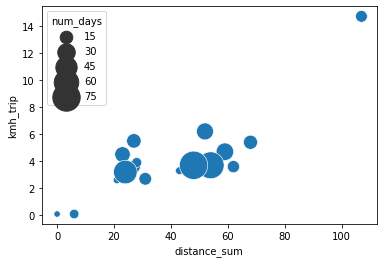

In [74]:
sns.scatterplot(data=device_agg, x="distance_sum", y="kmh_trip", size="num_days", sizes=(40, 800))

<AxesSubplot:xlabel='distance_sum', ylabel='max_trip'>

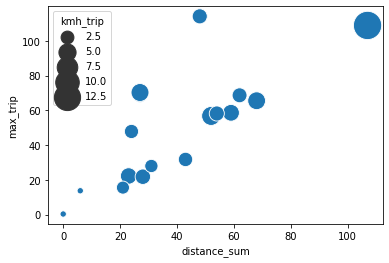

In [75]:
sns.scatterplot(data=device_agg, x="distance_sum", y="max_trip", size="kmh_trip", sizes=(40, 800))

<AxesSubplot:xlabel='distance_sum'>

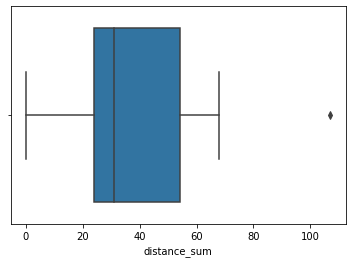

In [76]:
sns.boxplot(x=device_agg["distance_sum"])

##### 4.2 Recommandation de verdissement

L'article 77 de loi LOM vise à contraindre les entreprise de plus de 50 salariés et avec une flotte de plus de 100 véhicules d'acquérir 10% de voitures "propres" au prochain renouvellement de leur parc à partir de Janvier 2022. 

Cette loi ne s'applique pas à l'entreprise dont les données viennent d'être analysées. En effet, cette entreprise ne compte seulement que 30 véhicules dans sa flotte. 

Néanmoins, au regard des données analysées, il semblerait que les véhicules de cette entreprise n'éffectuent que de petits trajets par jour pour une distance parcourue moyenne de 30 km. 

Nous pourrions donc recommander à cette entreprise de favoriser un renouvellement de son parc en véhicules élétriques à condition de procéder à une analyse détaillée des possibilités de recharge sur les différents trajets empruntés par les conducteurs des véhicules (données de points GPS requises)

Au regard du coût des voitures électriques, il serait également intéréssant de renouveler les voitures dont l'usage est très fréquent afin, d'une part de rentabiliser l'investissement du véhicule et, d'autres part de limiter les émissions Co2 totale. 

##### 4.3 Pour aller plus loin

Cette analyse aurait pu être intéressente avec des données complémentaires comme: 

* les données de localisation GPS pour identifier les trajets récurrents, les trajets aller-retour et ceux effectués en ville 
* Les données liées au véhicule : marque, kilométrage, année de construction afin de recommander les véhicules à remplacer en premier 